In [52]:
from stdb import load_db 
import obspy 
import pickle
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import pandas as pd
import glob
from obspy import Trace
from obspy.signal.filter import envelope

from sklearn.decomposition import PCA

In [20]:
def calc_CpH(trE,trN):
    X = np.array([trE.data,trN.data])
    X = X.T
    pca = PCA(n_components=2)
    pca = pca.fit(X)
    eigval = pca.singular_values_
    values = 1-eigval[1]/eigval[0]
    return round(values,2)

def deltaphi(RCphi,SCphi):
    phi = max(abs(RCphi-SCphi),abs(SCphi-RCphi) )
    if phi >90:
        phi = 180-phi
    return phi

def init_pmotion(ax,title):
    ax.clear()
    ax.set_ylim((-1.2, 1.2))
    ax.set_xlim((-1.2, 1.2))
    ax.set_yticks(())
    ax.set_xticks(())
    ax.set_xlabel(r'W $\longleftrightarrow$ E')
    ax.set_ylabel(r'S $\longleftrightarrow$ N')
    ax.set_title(title, fontsize=16,fontweight='bold')
    return ax

def searchfile(path):
    calc_type = 'manual'
    Meta_pkl = path + '/Meta_manual.pkl'
    Station_data_pkl = path + '/Station_data.pkl'
    ZNE_pkl = path + '/ZNE_data.pkl'
    LQT_pkl = path + '/LQT_data.pkl'
    Split_result_pkl = path + '/Split_results_manual.pkl'
    SC_result_pkl = path + '/SC_res_manual.pkl'
    RC_result_pkl = path + '/RC_res_manual.pkl'

    Meta = pickle.load(open(Meta_pkl, "rb"))
    Station_data = pickle.load(open(Station_data_pkl, "rb"))
    ZNE = pickle.load(open(ZNE_pkl, "rb"))
    LQT = pickle.load(open(LQT_pkl, "rb"))
    Split_result = pickle.load(open(Split_result_pkl, "rb"))
    SC_res = pickle.load(open(SC_result_pkl, "rb"))
    RC_res = pickle.load(open(RC_result_pkl, "rb"))
    
    return calc_type,Meta,Station_data,ZNE,LQT,Split_result,SC_res,RC_res

In [73]:
def SNR(Meta, st, eq_time):
    arr_SKS = Meta.ttime
    phase = Meta.phase
    signalbegin = arr_SKS -5
    signalend   = arr_SKS +25
    if phase == 'SKS':
        noiseend    = arr_SKS -20 
        noisebegin  = arr_SKS -20-60
    else:
        arr_SKS = Meta.tSKS
        noiseend    = arr_SKS -20 
        noisebegin  = arr_SKS -20-60        


    dt = 10
    temp_tr = Trace(data=st.data)
    temp_tr.stats.delta = 1/dt
    temp_tr.stats.starttime = st.stats.starttime
    print(temp_tr)
    signal_SKS = temp_tr.slice(starttime=eq_time+signalbegin ,endtime = eq_time+signalend)
    print(signal_SKS)
    noise = temp_tr.slice(eq_time+noisebegin, eq_time+noiseend)


    signal_envelope_SKS = envelope(signal_SKS.data)
    noise_envelope = envelope(noise.data)

    cal_signal = sum(signal_envelope_SKS**2)
    cal_noise = sum(noise_envelope**2)

    SNR = cal_signal * 2 / cal_noise
    print(round(SNR,0))
    return round(SNR,0)

CpH0.9/20151121_090613
manual
2 pick
CpH0.9/20180930_105224
manual
2 pick


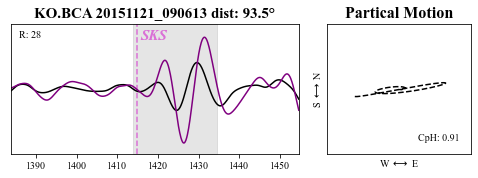

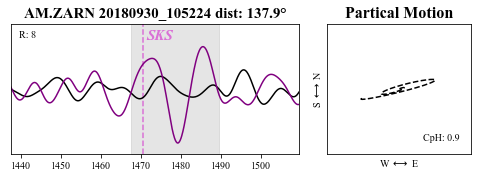

In [115]:
plt.rcParams["font.family"] = "Times New Roman"
path = 'CpH0.9'
for datapath in glob.glob(f'{path}/20*_??????'):
    fig = plt.figure(figsize=(8, 3), facecolor='w')
    eventtime = datapath.rsplit('/')[-1]
    print(datapath)
    calc_type,Meta,Station_data,ZNE,LQT,Split_result,SC_res,RC_res = searchfile(datapath)
    print(calc_type)
    try:
        
        win_begin = Meta.tpicked1
        win_end   = Meta.tpicked2
        print('2 pick')
    except:
        print('1 pick')
        win_begin = Meta.tpicked-5
        win_end   = Meta.tpicked+25
    t1 = Meta.time + win_begin #+ Meta.ttime 
    t2 = Meta.time + win_end   #+ Meta.ttime
    
    ZNE_use = ZNE.slice(t1,t2)
    ZNE_use = ZNE_use.filter('bandpass',freqmin=0.05,freqmax=0.125,corners=4,zerophase=True)
    CpH = Meta.CpH
    dp = deltaphi(RC_res.phi,SC_res.phi)
    
    ax0 = fig.add_axes([0.05, 0.0, 0.5, 0.6])
    time = LQT[0].times(reftime=Meta.time)
    LQT_use = LQT.slice(t1,t2)
    trQ  = LQT.select(component='Q')[0]
    trT  = LQT.select(component='T')[0]
    try: 
        if Meta.phase=='SKKS' or eventtime=='20170224_172844' :
            SKSSNR = SNR(Meta, trQ, Meta.time)
            plt.text(win_begin-28,0.9,f'R: {SKSSNR}', ha='left',va='bottom', fontsize=10)
        else:
            plt.text(win_begin-28,0.9,f'R: {Meta.threSNRQ}', ha='left',va='bottom', fontsize=10)
    except:
        print('calc')
        SKSSNR = SNR(Meta, trQ, Meta.time)
        plt.text(win_begin-28,0.9,f'R: {SKSSNR}', ha='left',va='bottom', fontsize=10)
    ax0.fill_between([win_begin,win_end],y1=-1.2,y2=1.2,color = 'grey',alpha = 0.2)
    pmax = max(max(abs(LQT_use[1].data)),max(abs(LQT_use[2].data)))
    plt.vlines(x=Meta.tpicked,ymin=-1.2,ymax=1.2, color = 'orchid',ls ='--')
    plt.text(Meta.tpicked+1, 0.9, f'{Meta.phase}', fontsize=15, color = 'orchid', ha='left',style='italic', weight='bold')
    plt.plot(time, trT.data/pmax, 'black')
    plt.plot(time, trQ.data/pmax, 'purple')
    plt.ylim(-1.2,1.2)
    plt.yticks([])
    plt.xlim(win_begin-30, win_end+20)

#     plt.text(win_end+20,-1,f'{Split_result.rsplit("/")[0]}  ', ha='right',va='bottom', fontsize=10)
#     plt.text(win_end+20,0.9,f'delphi: {round(dp,0)}°  ',ha='right',va='bottom', fontsize=10)
    plt.title(f'{Station_data.network}.{Station_data.station} {eventtime} dist: {round(Meta.gac,1)}°', fontsize=15, fontweight='bold')
    
    
    axp = fig.add_axes([0.6, 0.0,  0.25, 0.6])
    axp = init_pmotion(ax=axp,title = 'Partical Motion')
    if max(max(ZNE_use.select(component='E')[0].data/pmax), max(ZNE_use.select(component='N')[0].data/pmax)) >=0.5:
        axp.plot(ZNE_use.select(component='E')[0].data/pmax, ZNE_use.select(component='N')[0].data/pmax, 'k--') 
    else:
        axp.plot(ZNE_use.select(component='E')[0].data/pmax*1.4, ZNE_use.select(component='N')[0].data/pmax*1.4, 'k--')
    axp.text(1,-1,f'CpH: {CpH}',ha='right',va='bottom')
    
    fig.savefig(f'{path}/{eventtime}.png', dpi=200, bbox_inches='tight')
    fig.savefig(f'{path}/{eventtime}.pdf', bbox_inches='tight')
    